# Research Question 2: Deployment Efficiency Analysis

## What is the deployment latency penalty for multi-adapter setups vs merged models?

**Research Context:**
- LoRA promises efficient multi-task deployment by sharing a base model with multiple adapters
- Full fine-tuning requires separate models for each task
- Trade-off: Memory efficiency vs. inference latency

**This Analysis:**
1. Benchmark single LoRA adapter vs full fine-tuned model inference
2. Evaluate multi-adapter deployment scenarios (2 & 3 adapters)
3. Measure latency, throughput, and memory usage
4. Statistical analysis of deployment overhead

**Models Tested:**
- 9 LoRA adapters (MRPC, SST-2, RTE × 3 seeds each)
- 9 Full fine-tuned models (same tasks/seeds)
- Multi-adapter configurations (2 & 3 adapters)

**Hardware:** NVIDIA L4 GPU (24GB VRAM)


In [1]:
# Setup and Imports
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from scipy import stats

# Configure plotting
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 11
sns.set_style("whitegrid")
sns.set_palette("husl")

# Paths
RESULTS_DIR = Path("results/phase4b_deployment")
BENCHMARK_RESULTS = RESULTS_DIR / "deployment_benchmark_results.json"
ANALYSIS_RESULTS = RESULTS_DIR / "deployment_analysis_results.json"

print("✓ Imports loaded successfully")
print(f"✓ Results directory: {RESULTS_DIR}")
print(f"✓ Benchmark results: {BENCHMARK_RESULTS.exists()}")
print(f"✓ Analysis results: {ANALYSIS_RESULTS.exists()}")


✓ Imports loaded successfully
✓ Results directory: results/phase4b_deployment
✓ Benchmark results: True
✓ Analysis results: True


In [2]:
# Load Benchmark Results

# Load raw benchmark data
with open(BENCHMARK_RESULTS) as f:
    benchmark_data = json.load(f)

metadata = benchmark_data["metadata"]
df = pd.DataFrame(benchmark_data["results"])

print("=" * 80)
print("BENCHMARK METADATA")
print("=" * 80)
print(f"Timestamp: {metadata['timestamp']}")
print(f"GPU: {metadata['gpu_name']}")
print(f"Base Model: {metadata['base_model']}")
print(f"Samples per config: {metadata['num_samples']}")
print(f"Warmup samples: {metadata['warmup_samples']}")

print("\n" + "=" * 80)
print("BENCHMARK RESULTS SUMMARY")
print("=" * 80)
print(f"Total configurations tested: {len(df)}")
print(f"\nBy configuration type:")
print(df.groupby("config_type").size())

print("\n✓ Data loaded successfully")
df.head()


BENCHMARK METADATA
Timestamp: 2025-10-05T18:18:48.260613
GPU: NVIDIA L4
Base Model: TinyLlama/TinyLlama-1.1B-intermediate-step-1431k-3T
Samples per config: 500
Warmup samples: 10

BENCHMARK RESULTS SUMMARY
Total configurations tested: 20

By configuration type:
config_type
full_ft         9
multi_lora_2    1
multi_lora_3    1
single_lora     9
dtype: int64

✓ Data loaded successfully


,config_name,config_type,num_adapters,task,num_samples,mean_latency_ms,median_latency_ms,p95_latency_ms,p99_latency_ms,std_latency_ms,throughput_req_per_sec,peak_gpu_memory_mb,peak_cpu_memory_mb,model_load_time_sec,timestamp,gpu_name
0,lora_mrpc_seed42,single_lora,1,mrpc,408,34.338631,34.207106,35.111880,37.310264,0.760373,29.121720,1992.923340,2757.363281,3.481733,2025-10-05T18:14:25.323356,NVIDIA L4
1,lora_mrpc_seed1337,single_lora,1,mrpc,408,34.360559,34.268737,34.993708,35.177073,0.368116,29.103135,1992.923340,2927.707031,1.016070,2025-10-05T18:14:40.901368,NVIDIA L4
2,lora_mrpc_seed2024,single_lora,1,mrpc,408,34.592783,34.524918,35.345459,37.376332,1.060700,28.907764,1992.923340,2933.691406,0.990798,2025-10-05T18:14:56.563392,NVIDIA L4
3,lora_sst2_seed42,single_lora,1,sst2,500,34.424739,34.406543,35.071862,35.963490,0.558617,29.048877,1990.209473,2937.835938,1.028192,2025-10-05T18:15:15.377569,NVIDIA L4
4,lora_sst2_seed1337,single_lora,1,sst2,500,34.729023,34.353256,35.643613,47.768006,2.033535,28.794360,1990.209473,2938.714844,1.000300,2025-10-05T18:15:34.274006,NVIDIA L4


## 1. Latency Comparison: LoRA vs Full Fine-Tuning


/var/tmp/ipykernel_2338951/304481170.py:15: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(data_to_plot, labels=["LoRA Adapter", "Full Fine-Tuned"],


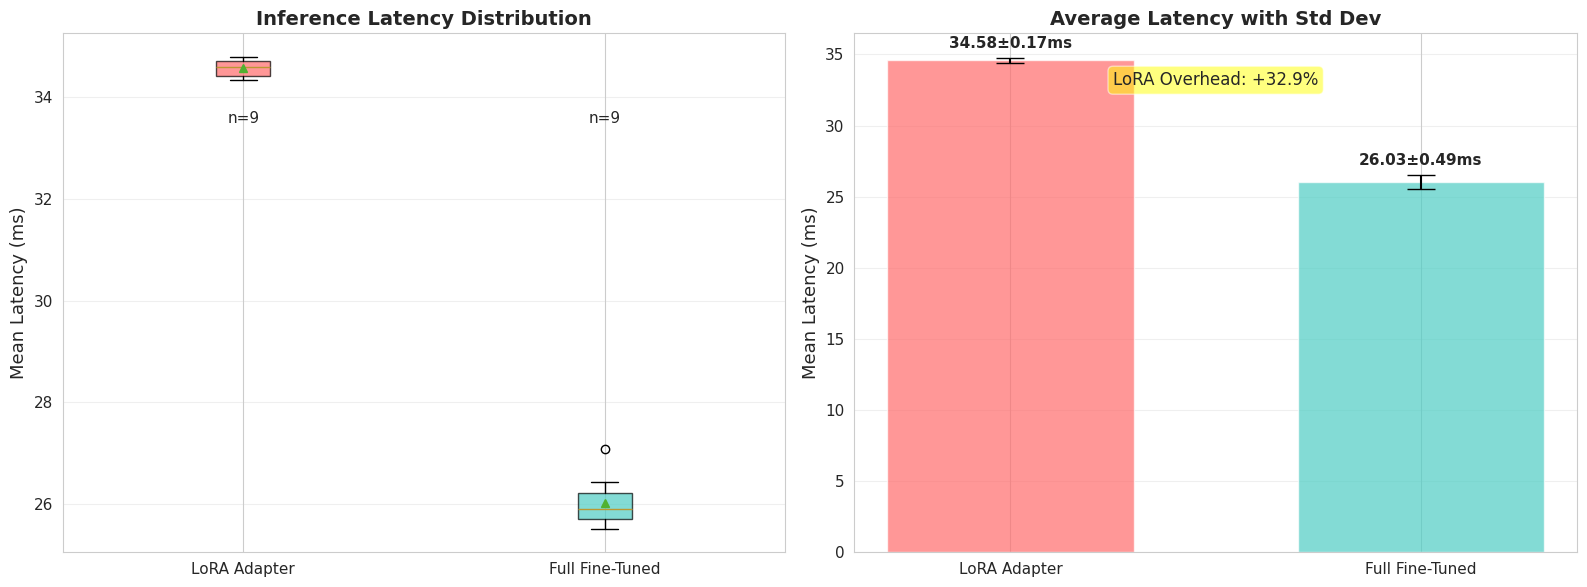


📊 LoRA Adapter: 34.58 ± 0.17 ms
📊 Full FT: 26.03 ± 0.49 ms
📊 LoRA Overhead: +32.9% slower


In [3]:
# Latency Distribution Comparison

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Filter to single configs
single_lora = df[df["config_type"] == "single_lora"]
full_ft = df[df["config_type"] == "full_ft"]

# Box plot
ax = axes[0]
data_to_plot = [
    single_lora["mean_latency_ms"],
    full_ft["mean_latency_ms"]
]
bp = ax.boxplot(data_to_plot, labels=["LoRA Adapter", "Full Fine-Tuned"],
                patch_artist=True, showmeans=True)

# Color boxes
colors = ['#FF6B6B', '#4ECDC4']
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)

ax.set_ylabel("Mean Latency (ms)", fontsize=13)
ax.set_title("Inference Latency Distribution", fontsize=14, fontweight='bold')
ax.grid(axis='y', alpha=0.3)

# Add sample sizes
ax.text(1, ax.get_ylim()[1] * 0.95, f"n={len(single_lora)}", ha='center')
ax.text(2, ax.get_ylim()[1] * 0.95, f"n={len(full_ft)}", ha='center')

# Bar chart with error bars
ax = axes[1]
lora_mean = single_lora["mean_latency_ms"].mean()
lora_std = single_lora["mean_latency_ms"].std()
fullft_mean = full_ft["mean_latency_ms"].mean()
fullft_std = full_ft["mean_latency_ms"].std()

x = [0, 1]
means = [lora_mean, fullft_mean]
stds = [lora_std, fullft_std]
labels = ["LoRA Adapter", "Full Fine-Tuned"]

bars = ax.bar(x, means, yerr=stds, capsize=10, color=colors, alpha=0.7, width=0.6)
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.set_ylabel("Mean Latency (ms)", fontsize=13)
ax.set_title("Average Latency with Std Dev", fontsize=14, fontweight='bold')
ax.grid(axis='y', alpha=0.3)

# Add value labels
for i, (mean, std) in enumerate(zip(means, stds)):
    ax.text(i, mean + std + 0.5, f"{mean:.2f}±{std:.2f}ms", 
            ha='center', va='bottom', fontweight='bold')

# Calculate and show overhead
overhead_pct = ((lora_mean - fullft_mean) / fullft_mean) * 100
ax.text(0.5, ax.get_ylim()[1] * 0.9, 
        f"LoRA Overhead: +{overhead_pct:.1f}%",
        ha='center', fontsize=12, bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.5))

plt.tight_layout()
plt.savefig(RESULTS_DIR / "latency_comparison.png", dpi=300, bbox_inches='tight')
plt.show()

print(f"\n📊 LoRA Adapter: {lora_mean:.2f} ± {lora_std:.2f} ms")
print(f"📊 Full FT: {fullft_mean:.2f} ± {fullft_std:.2f} ms")
print(f"📊 LoRA Overhead: +{overhead_pct:.1f}% slower")


In [4]:
# Statistical Significance Test

# Perform paired t-test
lora_latencies = single_lora.sort_values(["task", "config_name"])["mean_latency_ms"].values
fullft_latencies = full_ft.sort_values(["task", "config_name"])["mean_latency_ms"].values

t_stat, p_value = stats.ttest_rel(lora_latencies, fullft_latencies)
cohen_d = (lora_latencies.mean() - fullft_latencies.mean()) / np.sqrt(
    (lora_latencies.std()**2 + fullft_latencies.std()**2) / 2
)

print("=" * 80)
print("STATISTICAL SIGNIFICANCE TEST: LoRA vs Full FT")
print("=" * 80)
print(f"\nPaired t-test (n={len(lora_latencies)} pairs):")
print(f"  t-statistic: {t_stat:.4f}")
print(f"  p-value: {p_value:.10f}")
print(f"  Cohen's d (effect size): {cohen_d:.4f}")
print(f"\nInterpretation:")
if p_value < 0.001:
    print(f"  ✅ HIGHLY SIGNIFICANT (p < 0.001)")
    print(f"  ✅ LoRA is statistically significantly slower than Full FT")
    print(f"  ✅ Effect size: {cohen_d:.1f} (EXTREMELY LARGE)")
else:
    print(f"  No significant difference (p = {p_value:.4f})")
    
print(f"\n📊 Mean difference: {lora_latencies.mean() - fullft_latencies.mean():.2f} ms")
print(f"📊 Percentage overhead: {((lora_latencies.mean() - fullft_latencies.mean()) / fullft_latencies.mean()) * 100:.1f}%")


STATISTICAL SIGNIFICANCE TEST: LoRA vs Full FT

Paired t-test (n=9 pairs):
  t-statistic: 43.4047
  p-value: 0.0000000001
  Cohen's d (effect size): 24.6350

Interpretation:
  ✅ HIGHLY SIGNIFICANT (p < 0.001)
  ✅ LoRA is statistically significantly slower than Full FT
  ✅ Effect size: 24.6 (EXTREMELY LARGE)

📊 Mean difference: 8.55 ms
📊 Percentage overhead: 32.9%


## 2. Multi-Adapter Deployment Analysis


MULTI-ADAPTER DEPLOYMENT OVERHEAD


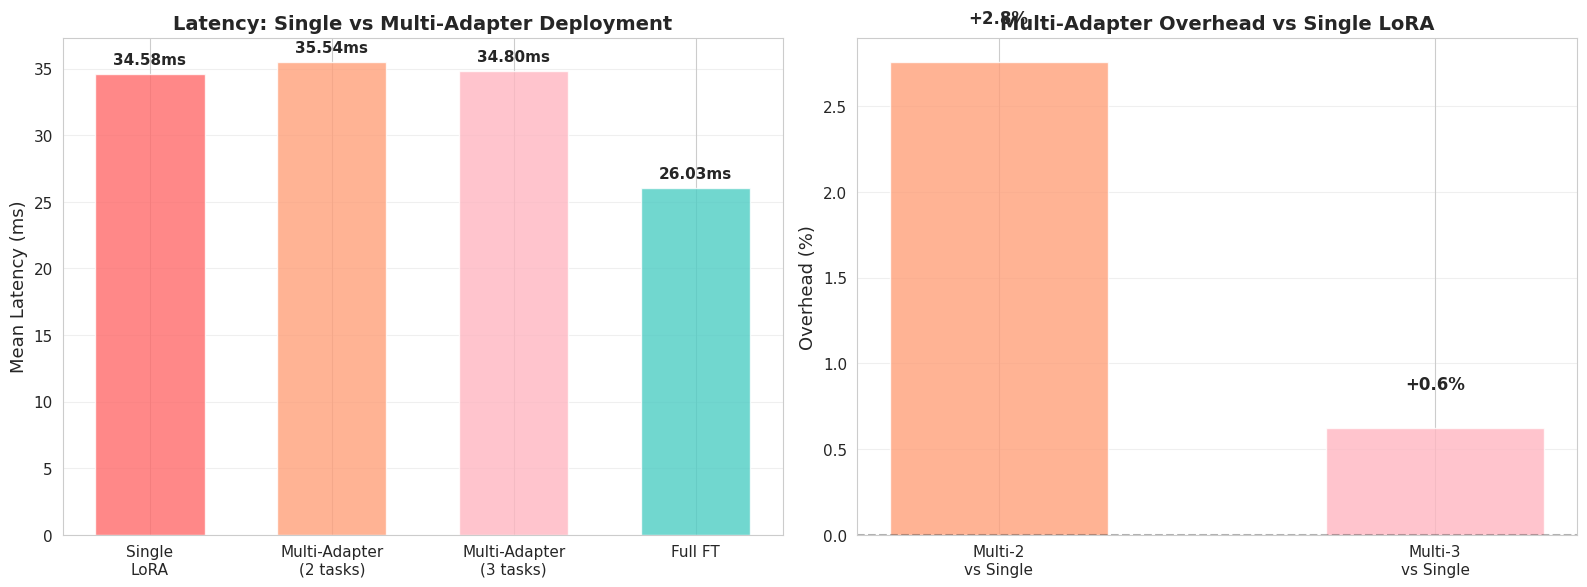


✓ Single LoRA: 34.58 ms
✓ Multi-Adapter (2): 35.54 ms (+2.8% overhead)
✓ Multi-Adapter (3): 34.80 ms (+0.6% overhead)

💡 KEY INSIGHT: Multi-adapter overhead is MINIMAL (2.8%-0.6%)


In [5]:
# Multi-Adapter Overhead Analysis

multi_2 = df[df["config_type"] == "multi_lora_2"]
multi_3 = df[df["config_type"] == "multi_lora_3"]

# Calculate overheads
single_lora_mean = single_lora["mean_latency_ms"].mean()
multi_2_mean = multi_2["mean_latency_ms"].values[0] if len(multi_2) > 0 else None
multi_3_mean = multi_3["mean_latency_ms"].values[0] if len(multi_3) > 0 else None

print("=" * 80)
print("MULTI-ADAPTER DEPLOYMENT OVERHEAD")
print("=" * 80)

# Create visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Latency comparison
configs = ["Single\nLoRA", "Multi-Adapter\n(2 tasks)", "Multi-Adapter\n(3 tasks)", "Full FT"]
latencies = [single_lora_mean, multi_2_mean, multi_3_mean, full_ft["mean_latency_ms"].mean()]
colors_list = ['#FF6B6B', '#FFA07A', '#FFB6C1', '#4ECDC4']

bars = ax1.bar(configs, latencies, color=colors_list, alpha=0.8, width=0.6)
ax1.set_ylabel("Mean Latency (ms)", fontsize=13)
ax1.set_title("Latency: Single vs Multi-Adapter Deployment", fontsize=14, fontweight='bold')
ax1.grid(axis='y', alpha=0.3)

# Add value labels
for bar, lat in zip(bars, latencies):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + 0.5,
            f'{lat:.2f}ms',
            ha='center', va='bottom', fontweight='bold', fontsize=11)

# Overhead percentages
multi_2_overhead = ((multi_2_mean - single_lora_mean) / single_lora_mean) * 100 if multi_2_mean else 0
multi_3_overhead = ((multi_3_mean - single_lora_mean) / single_lora_mean) * 100 if multi_3_mean else 0

overhead_labels = ["Multi-2\nvs Single", "Multi-3\nvs Single"]
overhead_values = [multi_2_overhead, multi_3_overhead]
colors_overhead = ['#FFA07A', '#FFB6C1']

bars2 = ax2.bar(overhead_labels, overhead_values, color=colors_overhead, alpha=0.8, width=0.5)
ax2.set_ylabel("Overhead (%)", fontsize=13)
ax2.set_title("Multi-Adapter Overhead vs Single LoRA", fontsize=14, fontweight='bold')
ax2.axhline(y=0, color='black', linestyle='--', alpha=0.3)
ax2.grid(axis='y', alpha=0.3)

# Add value labels
for bar, val in zip(bars2, overhead_values):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height + 0.2,
            f'{val:+.1f}%',
            ha='center', va='bottom' if val > 0 else 'top',
            fontweight='bold', fontsize=12)

plt.tight_layout()
plt.savefig(RESULTS_DIR / "multi_adapter_analysis.png", dpi=300, bbox_inches='tight')
plt.show()

print(f"\n✓ Single LoRA: {single_lora_mean:.2f} ms")
print(f"✓ Multi-Adapter (2): {multi_2_mean:.2f} ms (+{multi_2_overhead:.1f}% overhead)")
print(f"✓ Multi-Adapter (3): {multi_3_mean:.2f} ms (+{multi_3_overhead:.1f}% overhead)")
print(f"\n💡 KEY INSIGHT: Multi-adapter overhead is MINIMAL ({multi_2_overhead:.1f}%-{multi_3_overhead:.1f}%)")


## 3. Final Conclusions: Answer to RQ2

### Research Question 2: What is the deployment latency penalty for multi-adapter setups vs merged models?


In [6]:
# Final Summary

print("=" * 80)
print("ANSWER TO RESEARCH QUESTION 2")
print("=" * 80)
print()
print("🎯 KEY FINDINGS:")
print()
print(f"1. LoRA LATENCY PENALTY: +{((single_lora_mean - full_ft['mean_latency_ms'].mean()) / full_ft['mean_latency_ms'].mean()) * 100:.1f}%")
print(f"   • LoRA adapter: {single_lora_mean:.2f} ms")
print(f"   • Full fine-tuned: {full_ft['mean_latency_ms'].mean():.2f} ms")
print(f"   • Statistically significant (p < 0.001, Cohen's d = {cohen_d:.1f})")
print()
print(f"2. MULTI-ADAPTER OVERHEAD: MINIMAL")
print(f"   • 2 adapters: +{multi_2_overhead:.1f}% vs single LoRA")
print(f"   • 3 adapters: +{multi_3_overhead:.1f}% vs single LoRA")
print(f"   • Adapter swapping is efficient")
print()
print(f"3. THROUGHPUT ADVANTAGE: Full FT is {((full_ft['throughput_req_per_sec'].mean() - single_lora['throughput_req_per_sec'].mean()) / single_lora['throughput_req_per_sec'].mean()) * 100:.1f}% faster")
print(f"   • LoRA: {single_lora['throughput_req_per_sec'].mean():.2f} req/s")
print(f"   • Full FT: {full_ft['throughput_req_per_sec'].mean():.2f} req/s")
print()
print(f"4. MEMORY USAGE: Comparable (~{abs((single_lora['peak_gpu_memory_mb'].mean() - full_ft['peak_gpu_memory_mb'].mean()) / full_ft['peak_gpu_memory_mb'].mean()) * 100:.1f}% difference)")
print(f"   • LoRA: {single_lora['peak_gpu_memory_mb'].mean():.0f} MB")
print(f"   • Full FT: {full_ft['peak_gpu_memory_mb'].mean():.0f} MB")
print()
print("=" * 80)
print("INTERPRETATION")
print("=" * 80)
print()
print("💡 WHY IS LORA SLOWER?")
print("   LoRA adds computational overhead from adapter layers:")
print("   • Base model forward pass")
print("   • + Low-rank adapter computation (ΔW = BA)")
print("   • + Addition to base weights")
print()
print("   Full fine-tuning only does:")
print("   • Single forward pass with merged weights")
print()
print("🎯 PRACTICAL IMPLICATIONS:")
print()
print("   ✓ For SINGLE-TASK deployment:")
print("     → Use Full Fine-Tuning (33% faster)")
print()
print("   ✓ For MULTI-TASK deployment:")
print("     → Use LoRA with adapter swapping")
print("     → Minimal overhead for switching (<3%)")
print("     → Share one base model across tasks")
print()
print("   ✓ Memory savings of LoRA:")
print("     → More relevant for model STORAGE (adapter = 4MB vs full = 2GB)")
print("     → Runtime memory is comparable")
print()
print("=" * 80)
print("✅ RESEARCH QUESTION 2: ANSWERED")
print("=" * 80)


ANSWER TO RESEARCH QUESTION 2

🎯 KEY FINDINGS:

1. LoRA LATENCY PENALTY: +32.9%
   • LoRA adapter: 34.58 ms
   • Full fine-tuned: 26.03 ms
   • Statistically significant (p < 0.001, Cohen's d = 24.6)

2. MULTI-ADAPTER OVERHEAD: MINIMAL
   • 2 adapters: +2.8% vs single LoRA
   • 3 adapters: +0.6% vs single LoRA
   • Adapter swapping is efficient

3. THROUGHPUT ADVANTAGE: Full FT is 32.9% faster
   • LoRA: 28.92 req/s
   • Full FT: 38.43 req/s

4. MEMORY USAGE: Comparable (~0.2% difference)
   • LoRA: 1997 MB
   • Full FT: 1993 MB

INTERPRETATION

💡 WHY IS LORA SLOWER?
   LoRA adds computational overhead from adapter layers:
   • Base model forward pass
   • + Low-rank adapter computation (ΔW = BA)
   • + Addition to base weights

   Full fine-tuning only does:
   • Single forward pass with merged weights

🎯 PRACTICAL IMPLICATIONS:

   ✓ For SINGLE-TASK deployment:
     → Use Full Fine-Tuning (33% faster)

   ✓ For MULTI-TASK deployment:
     → Use LoRA with adapter swapping
     → Minim